#Importación Librerías


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Proyecto Inteligencia Computacional/df_2.xlsx'
df = pd.read_excel(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Tratamiento de Datos

Eliminamos las variables con mas de 150 valores nulos

In [3]:
df_copy = df.copy()
for i in df_copy:
  if df_copy[i].isna().sum() >= 150:
     df_copy = df_copy.drop(columns = [i]) 

Por lo tanto juntaremos clases las clases SNIIb, SNIIn y SNII en una sola clase puesto que tiene pocos ejemplos


SNIa     1394
SNII      356
SNIbc      93
SLSN       33
Name: classALeRCE, dtype: int64

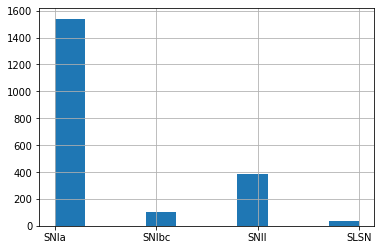

In [4]:
df_copy['classALeRCE']= df_copy['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')
df_copy['classALeRCE'].hist()
df_copy = df_copy.dropna()
df_copy['classALeRCE'].value_counts()

Separamos el dataset en entrenamiento y testeo, ademas de balancear los datos usando SMOTE 

/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1394) in class SNIa will be larger than the number of samples in the majority class (class #SNIa -> 930)
  warnings.warn(


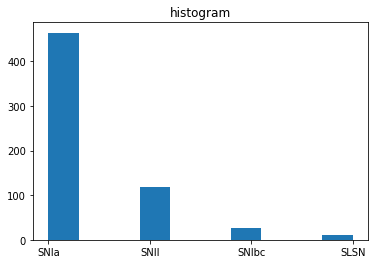

[['SLSN' 11]
 ['SNII' 118]
 ['SNIa' 464]
 ['SNIbc' 27]]


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
Le = LabelEncoder()
X = df_copy.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_copy['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)


#Ahora abalanceamos los datos previamente a aplicar los modelos
from imblearn.over_sampling import SMOTE
sm= SMOTE(sampling_strategy = {'SLSN': 600 , 'SNII': 356*2, 'SNIa': 1394, 'SNIbc': 96*2})
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
X_train, y_train = X_train_smote, y_train_smote

#Veamos cuantos valores quedan en el conjunto de test
plt.hist(y_test) 
plt.title("histogram") 
plt.show()
unique, counts = np.unique(y_test, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

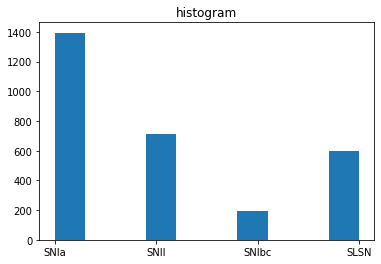

[['SLSN' 600]
 ['SNII' 712]
 ['SNIa' 1394]
 ['SNIbc' 192]]


In [6]:
plt.hist(y_train) 
plt.title("histogram") 
plt.show()
unique, counts = np.unique(y_train, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

# Random Forest sin balance

Entrenaremos un modelo de Random Forest sin balancear

In [7]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_RF.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos como se comporta este modelo con algunas metricas de error, como la matriz de confusion y la metrica balance accuracy

Classification report RF
              precision    recall  f1-score   support

        SLSN       0.43      0.27      0.33        11
        SNII       0.83      0.69      0.75       118
        SNIa       0.89      0.98      0.93       464
       SNIbc       0.00      0.00      0.00        27

    accuracy                           0.87       620
   macro avg       0.54      0.49      0.50       620
weighted avg       0.83      0.87      0.85       620

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


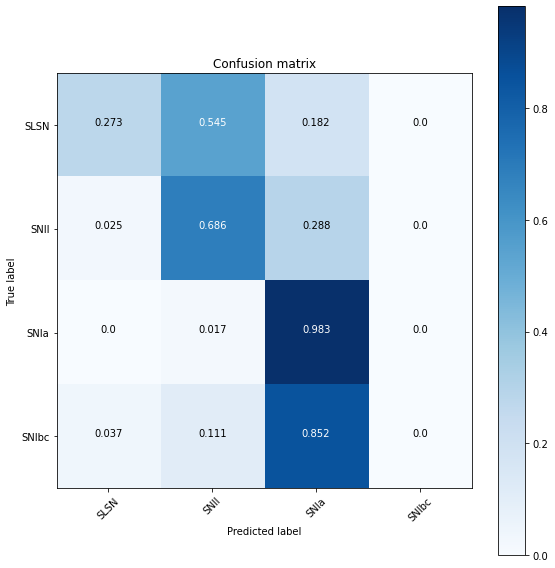

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
y_predict = model_RF.predict(X_test)
#Comparamos con classification_report
print('Classification report RF')
print(classification_report(y_test, y_predict))
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_RF.classes_], normalize=True)

Balance Accuracy Score modelo simple de RF

In [9]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo simple de RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo simple de RF:  0.48548164284575734


# Random Forest con balance

Ahora veremos como se comporta para un modelo de Balanced Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

model_B_RF = BalancedRandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_B_RF.fit(X_train, y_train) 

BalancedRandomForestClassifier(class_weight='balanced', max_depth=30,
                               max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos como se comporta este modelo con algunas metricas de error, como la matriz de confusion y la metrica balanced accuracy

Classification report RF
              precision    recall  f1-score   support

        SLSN       0.50      0.55      0.52        11
        SNII       0.66      0.73      0.69       118
        SNIa       0.91      0.89      0.90       464
       SNIbc       0.16      0.15      0.15        27

    accuracy                           0.82       620
   macro avg       0.56      0.58      0.57       620
weighted avg       0.82      0.82      0.82       620

Normalized confusion matrix


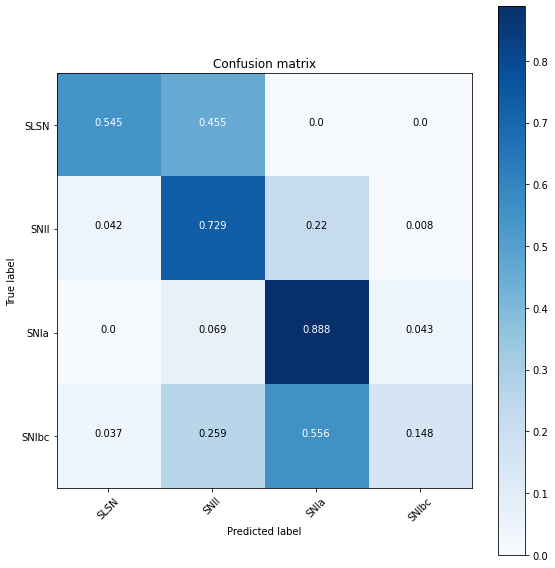

In [11]:
y_predict = model_B_RF.predict(X_test)
#Comparamos con classification_report
print('Classification report RF')
print(classification_report(y_test, y_predict))
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_B_RF.classes_], normalize=True)

Balance Accuracy Score modelo Balanced RF

In [12]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo Balanced RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo Balanced RF:  0.5775868218518714


In [13]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif


params_svc = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__kernel' : ['linear', 'poly', 'rbf'],
    'Clasificador__decision_function_shape' : ['ovo', 'ovr'],
    'Clasificador__class_weight': [None, 'balanced'],
}]




param_rf = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__n_estimators' : [80, 100, 120],
    'Clasificador__criterion' : ['gini', 'entropy'],
    'Clasificador__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'Clasificador__class_weight': ['balanced', 'balanced_subsample', None]


}]


params_balanced_rf = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__criterion' : ['gini', 'entropy'],
    'Clasificador__n_estimators' : [80, 100, 120],
    'Clasificador__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'Clasificador__class_weight': ['balanced', 'balanced_subsample', None]

}]

In [14]:
model_svc = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', SVC())
])




model_rf = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', RandomForestClassifier())

])


model_balanced_rf = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', BalancedRandomForestClassifier())
])


In [15]:
model_svc = HalvingGridSearchCV(model_svc, params_svc, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)

In [16]:
model_rf = HalvingGridSearchCV(model_rf, param_rf, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/pyth

In [17]:
model_balanced_rf = HalvingGridSearchCV(model_balanced_rf, params_balanced_rf, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classe

Balanced Accuracy model svc:  0.5659936841628834
              precision    recall  f1-score   support

        SLSN       0.28      0.64      0.39        11
        SNII       0.54      0.64      0.58       118
        SNIa       0.94      0.73      0.82       464
       SNIbc       0.07      0.26      0.11        27

    accuracy                           0.69       620
   macro avg       0.46      0.57      0.48       620
weighted avg       0.82      0.69      0.74       620

Mejores Parametros SVC
Pipeline(steps=[('Selection', SelectPercentile(percentile=90)),
                ('Clasificador',
                 SVC(class_weight='balanced', decision_function_shape='ovo',
                     kernel='linear'))])
Matriz de Confusion
Normalized confusion matrix


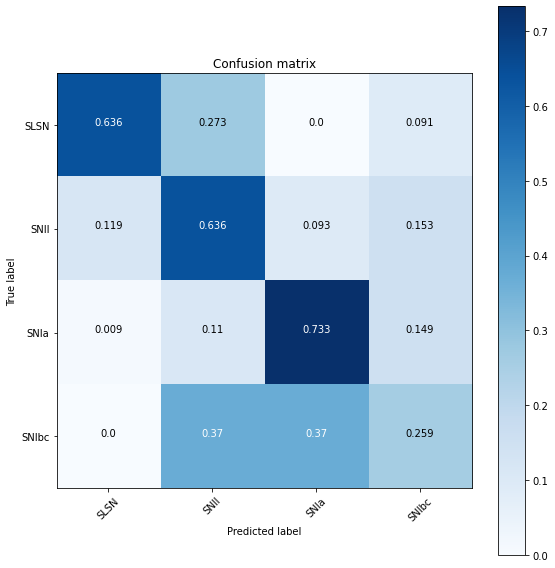

-----------------------------------------------------------------------------------
Balanced Accuracy model rf:  0.598842014534592
              precision    recall  f1-score   support

        SLSN       0.36      0.73      0.48        11
        SNII       0.65      0.69      0.67       118
        SNIa       0.92      0.86      0.89       464
       SNIbc       0.08      0.11      0.09        27

    accuracy                           0.80       620
   macro avg       0.50      0.60      0.53       620
weighted avg       0.82      0.80      0.81       620

Mejores Parametros RF
Pipeline(steps=[('Selection', SelectPercentile(percentile=90)),
                ('Clasificador',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        n_estimators=80))])
Normalized confusion matrix


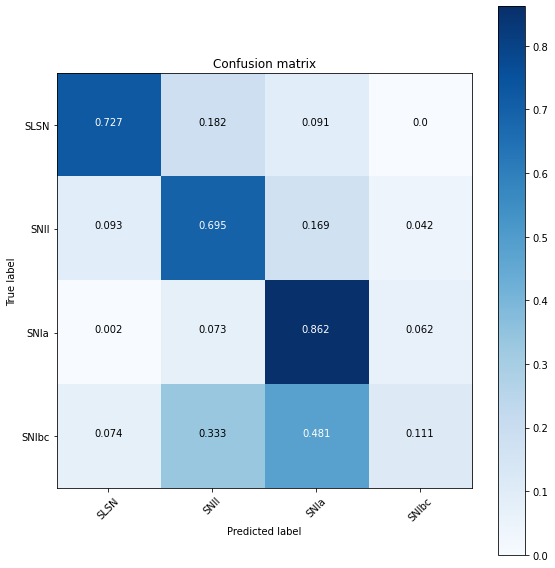

-----------------------------------------------------------------------------------
Balanced Accuracy model  balanced rf:  0.5734250809773165
              precision    recall  f1-score   support

        SLSN       0.42      0.45      0.43        11
        SNII       0.71      0.80      0.75       118
        SNIa       0.93      0.89      0.91       464
       SNIbc       0.13      0.15      0.14        27

    accuracy                           0.84       620
   macro avg       0.55      0.57      0.56       620
weighted avg       0.85      0.84      0.84       620

Mejores Parametros  Balanced RF
Pipeline(steps=[('Selection', SelectPercentile(percentile=90)),
                ('Clasificador',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                criterion='entropy',
                                                max_depth=20,
                                                n_estimators=120))])
Normalized confusion 

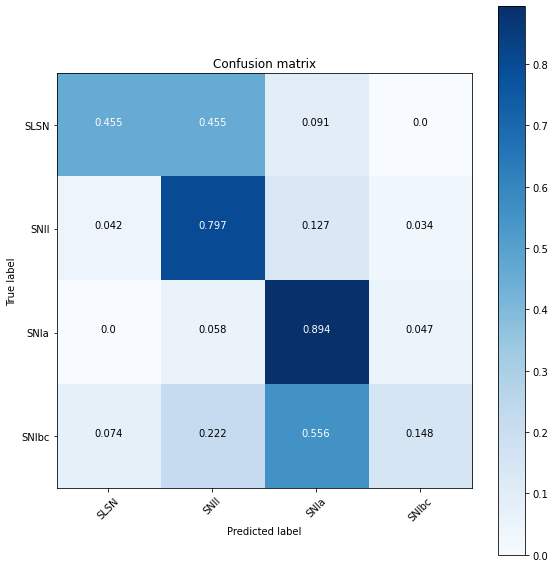

In [18]:
y_pred_svc = model_svc.predict(X_test)
#Comparamos con classification_report
print('Balanced Accuracy model svc: ', balanced_accuracy_score(y_test, y_pred_svc) )
print(classification_report(y_test, y_pred_svc))
print('Mejores Parametros SVC')
print(model_svc.best_estimator_)
print('Matriz de Confusion')
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(cm, [*model_svc.classes_], normalize=True)

print('-----------------------------------------------------------------------------------')

y_pred_rf = model_rf.predict(X_test)
#Comparamos con classification_report
print('Balanced Accuracy model rf: ', balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('Mejores Parametros RF')
print(model_rf.best_estimator_)
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, [*model_rf.classes_], normalize=True)

print('-----------------------------------------------------------------------------------')


y_pred_balanced_rf = model_balanced_rf.predict(X_test)
print('Balanced Accuracy model  balanced rf: ', balanced_accuracy_score(y_test, y_pred_balanced_rf))
print(classification_report(y_test, y_pred_balanced_rf))
print('Mejores Parametros  Balanced RF')
print(model_balanced_rf.best_estimator_)
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_balanced_rf)
plot_confusion_matrix(cm, [*model_balanced_rf.classes_], normalize=True)
